In [1]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchmetrics import F1Score
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import GPUtil
import cv2
import os
import gc

In [2]:
gc.collect()
torch.cuda.empty_cache()
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  7% |  0% |


In [3]:
random_seed = 12
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
train_dir_path = '/opt/ml/input/data/train/'
train_image_path = '/opt/ml/input/data/train/images/'

dt_train = pd.read_csv(train_dir_path+'train.csv')
dt_train


,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [5]:
def get_age_range(age):
    if age < 30:
        return 0
    elif 30 <= age < 60:
        return 1
    else:
        return 2
    
    
dt_train['age_range'] = dt_train['age'].apply(lambda x : get_age_range(x))
dt_train

,id,gender,race,age,path,age_range
0,000001,female,Asian,45,000001_female_Asian_45,1
1,000002,female,Asian,52,000002_female_Asian_52,1
2,000004,male,Asian,54,000004_male_Asian_54,1
3,000005,female,Asian,58,000005_female_Asian_58,1
4,000006,female,Asian,59,000006_female_Asian_59,1
...,...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19,0
2696,006955,male,Asian,19,006955_male_Asian_19,0
2697,006956,male,Asian,19,006956_male_Asian_19,0
2698,006957,male,Asian,20,006957_male_Asian_20,0


In [6]:
#### 데이터 증강은 여기서 쓰면 좋을듯?
#### 60세 이상 데이터 6배 증강 필요

In [7]:
train_idx, valid_idx = train_test_split(np.arange(len(dt_train)),
                                       test_size=0.2,
                                       shuffle=True,
                                       stratify=dt_train['age_range'])

train_image, train_label = [], []
valid_image, valid_label = [], []

for idx in train_idx:
    path = dt_train.iloc[idx]['path']
    for file_name in [i for i in os.listdir(train_image_path+path) if i[0] != '.']:
        train_image.append(train_image_path+path+'/'+file_name)
        train_label.append((path.split('_')[1], path.split('_')[3], file_name.split('.')[0]))  
        
for idx in valid_idx:
    path = dt_train.iloc[idx]['path']
    for file_name in [i for i in os.listdir(train_image_path+path) if i[0] != '.']:
        valid_image.append(train_image_path+path+'/'+file_name)
        valid_label.append((path.split('_')[1], path.split('_')[3], file_name.split('.')[0])) 

In [8]:
train_data = pd.Series(train_image)
train_label = pd.Series(train_label)

valid_data = pd.Series(valid_image)
valid_label = pd.Series(valid_label)

In [9]:
def onehot_enc(x):
    def gender(i):
        if i == 'male':
            return 0
        elif i == 'female':
            return 3
    def age(j):
        j = int(j)
        if j < 30:
            return 0
        elif j >= 30 and j < 60:
            return 1
        elif j >= 60:
            return 2
    def mask(k):
        if k == 'normal':
            return 12
        elif 'incorrect' in k:
            return 6
        else:
            return 0
    return gender(x[0]) + age(x[1]) + mask(x[2])

In [10]:
def enc_sepclass(x):
    # x 입력형식 : (성별, 나이, 마스크) 튜플
    # 출력형식 : (성별인코딩, 나이인코딩, 마스크인코딩)
    def gender(i):
        if i == 'male':
            return 0
        elif i == 'female':
            return 1
    def age(j):
        j = int(j)
        if j < 30:
            return 0
        elif j >= 30 and j < 60:
            return 1
        else:
            return 2
    def mask(k):
        if k == 'normal':
            return 2
        elif 'incorrect' in k:
            return 1
        else:
            return 0
    return gender(x[0]), age(x[1]), mask(x[2])

In [11]:
class Dataset_Mask(Dataset):
    def __init__(self, data, label, encoding=True, midcrop=True, transform=None):
        self.encoding = encoding
        self.midcrop = midcrop
        self.data = data
        self.label = label
        self.transform = transform
        
        if encoding:
            self.label = self.label.apply(enc_sepclass)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X = cv2.cvtColor(cv2.imread(self.data[idx]), cv2.COLOR_BGR2RGB)
        y = self.label[idx]
        
        if self.midcrop:
            X = X[70:420, 17:367]
        
        if self.transform:
            return self.transform(X), y
        return X, y

In [12]:
mask_train_set = Dataset_Mask(data=train_data, label=train_label, transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                            ]))
mask_val_set = Dataset_Mask(data=valid_data, label=valid_label, transform = transforms.Compose([
                                transforms.ToTensor()
                            ]))

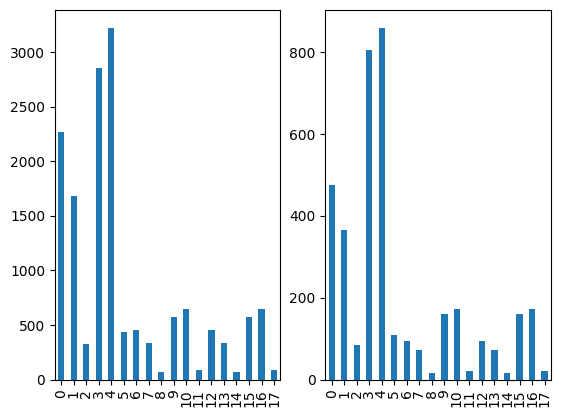

In [13]:
def vec2label(x):
    return 3*x[0] + x[1] + 6*x[2]

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

t_image = [mask_train_set[i][1] for i in range(len(mask_train_set))]
v_image = [mask_val_set[i][1] for i in range(len(mask_val_set))]

t_Series = pd.Series(t_image).apply(vec2label).value_counts().sort_index()
v_Series = pd.Series(v_image).apply(vec2label).value_counts().sort_index()

t_Series.plot(kind='bar', ax = ax1)
v_Series.plot(kind='bar', ax = ax2)

In [14]:
print(f'training data size : {len(mask_train_set)}')
print(f'validation data size : {len(mask_val_set)}')

training data size : 15120
validation data size : 3780


In [15]:
label_srs = pd.Series(t_image)

def sampler_weight(srs):
    num_per_label = dict(srs.value_counts())
    num_data = len(srs)
    
    return [num_data / num_per_label[i] for i in srs], num_data

sampler = WeightedRandomSampler(*sampler_weight(label_srs))

In [16]:
batch_size = 256

train_dataloader_mask = DataLoader(dataset = mask_train_set, batch_size=batch_size, num_workers=2, sampler = sampler)
val_dataloader_mask = DataLoader(dataset = mask_val_set, batch_size=batch_size, num_workers=2)

In [17]:
# pretrained된 파라미터 불러오기 + out1, out2, out3 파라미터 추가
weight = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.get_state_dict(progress=True)
for i in ['out1.weight', 'out1.bias', 'out2.weight', 'out2.bias', 'out3.weight', 'out3.bias']:
    if 'bias' in i:
        if 'out1' in i:
            weight[i] = torch.randn(2)
        else:
            weight[i] = torch.rand(3)
    else:
        if 'out1' in i:
            weight[i] = torch.randn(2, 512)
        else:
            weight[i] = torch.randn(3, 512)

In [18]:
class R18_MultiClass(torchvision.models.ResNet):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.out1 = nn.Linear(512, 2, bias=True)
        self.out2 = nn.Linear(512, 3, bias=True)
        self.out3 = nn.Linear(512, 3, bias=True)
        
    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # out1 : gender class
        # out2 : age class
        # out3 : mask class
        out1 = self.out1(x)
        out2 = self.out2(x)
        out3 = self.out3(x)
        
        return out1, out2, out3

In [19]:
block = torchvision.models.resnet.BasicBlock
layers = [2, 2, 2, 2]

basemodel_resnet18 = R18_MultiClass(block = block, layers = layers)
basemodel_resnet18.load_state_dict(weight)
print(basemodel_resnet18)

R18_MultiClass(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [20]:
import math
nn.init.xavier_uniform_(basemodel_resnet18.out1.weight)
stdv = 1. / math.sqrt(basemodel_resnet18.out1.weight.size(1))
basemodel_resnet18.out1.bias.data.uniform_(-stdv, stdv)

nn.init.xavier_uniform_(basemodel_resnet18.out2.weight)
stdv = 1. / math.sqrt(basemodel_resnet18.out2.weight.size(1))
basemodel_resnet18.out2.bias.data.uniform_(-stdv, stdv)

nn.init.xavier_uniform_(basemodel_resnet18.out3.weight)
stdv = 1. / math.sqrt(basemodel_resnet18.out3.weight.size(1))
basemodel_resnet18.out3.bias.data.uniform_(-stdv, stdv)

tensor([ 0.0115, -0.0163,  0.0383])

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

basemodel_resnet18.to(device)

LEARNING_RATE = 0.0001
NUM_EPOCH = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basemodel_resnet18.parameters(), lr=LEARNING_RATE)

using cuda:0


In [22]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(basemodel_resnet18.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy()
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[conv1.weight] shape:[(64, 3, 7, 7)].
    val:[-0.01  -0.006 -0.002  0.075  0.057]
[1] name:[bn1.weight] shape:[(64,)].
    val:[ 2.349e-01  2.663e-01 -5.110e-08  5.187e-01  3.440e-09]
[2] name:[bn1.bias] shape:[(64,)].
    val:[ 2.307e-01  2.538e-01 -1.054e-06 -6.644e-01 -1.657e-08]
[3] name:[layer1.0.conv1.weight] shape:[(64, 64, 3, 3)].
    val:[ 0.058 -0.095 -0.02  -0.075 -0.799]
[4] name:[layer1.0.bn1.weight] shape:[(64,)].
    val:[0.309 0.215 0.237 0.426 0.514]
[5] name:[layer1.0.bn1.bias] shape:[(64,)].
    val:[ 0.166  0.242  0.178 -0.043 -0.205]
[6] name:[layer1.0.conv2.weight] shape:[(64, 64, 3, 3)].
    val:[ 0.026 -0.105 -0.005 -0.086 -0.33 ]
[7] name:[layer1.0.bn2.weight] shape:[(64,)].
    val:[0.25  0.22  0.276 0.607 0.265]
[8] name:[layer1.0.bn2.bias] shape:[(64,)].
    val:[ 0.228  0.009 -0.067 -0.069  0.36 ]
[9] name:[layer1.1.conv1.weight] shape:[(64, 64, 3, 3)].
    val:[ 0.02  -0.005 -0.004 -0.02  -0.012]
[10] name:[layer1.1.bn1.weight] shape:[(64,)].
   

In [23]:
best_val_acc = 0
best_val_loss = np.inf

f1 = F1Score(num_classes = 18, average='macro', mdmc_reduce='samplewise').to(device)
best_f1_score = 0


for epoch in range(NUM_EPOCH):
    matches = 0
    loss_value = 0
    basemodel_resnet18.train()

    # 학습 시작!
    for inputs, labels in train_dataloader_mask:
        inputs = inputs.to(device)
        gen, age, msk = labels
        gen = gen.to(device)
        age = age.to(device)
        msk = msk.to(device)
        
        p_gen, p_age, p_msk = basemodel_resnet18(inputs)
        p_gen, p_age, p_msk = F.softmax(p_gen), F.softmax(p_age), F.softmax(p_msk)
        loss = criterion(p_gen, gen) + criterion(p_age, age) + criterion(p_msk, msk)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # epoch 5마다 모델 저장
        if (epoch+1) % 5 == 0:
            torch.save(basemodel_resnet18, '/opt/ml/checkpoint/resnet18_RHF_WRS/checkpoint_ep_{}.pt'.format(epoch+1))

        loss_value = loss.item()
        matches = ((torch.argmax(p_gen, -1) == gen) & (torch.argmax(p_age, -1) == age) & (torch.argmax(p_msk, -1) == msk)).sum().item()

        train_loss = loss_value / len(labels)
        train_acc = matches / len(labels)
    print(f"epoch[{epoch+1}/{NUM_EPOCH}] training loss {train_loss:.3f}, training accuracy {train_acc:.3f}")        
    
    
    with torch.no_grad():
        basemodel_resnet18.eval()
        val_loss_items = []
        val_acc_items = []
        
        for inputs, labels in val_dataloader_mask:
            inputs = inputs.to(device)
            gen, age, msk = labels
            gen = gen.to(device)
            age = age.to(device)
            msk = msk.to(device)
            
            result = basemodel_resnet18(inputs)
            p_gen, p_age, p_msk = result
            p_gen, p_age, p_msk = F.softmax(p_gen), F.softmax(p_age), F.softmax(p_msk)
            loss = criterion(p_gen, gen) + criterion(p_age, age) + criterion(p_msk, msk)
            
            loss_item = loss.item()
            acc_item = ((torch.argmax(p_gen, -1) == gen) & (torch.argmax(p_age, -1) == age) & (torch.argmax(p_msk, -1) == msk)).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)
            
        val_loss = np.sum(val_loss_items) / len(val_dataloader_mask)
        val_acc = np.sum(val_acc_items) / len(mask_val_set)
        
        pred_label = torch.vstack((torch.argmax(p_gen, -1), torch.argmax(p_age, -1), torch.argmax(p_gen, -1))).T
        real_label = torch.vstack((gen, age, msk)).T
        f1_score = f1(pred_label, real_label)
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            torch.save(basemodel_resnet18, '/opt/ml/checkpoint/resnet18_RHF_WRS/checkpoint_best.pt')
        
        print(f"[val] acc : {val_acc:.3f}, loss : {val_loss:.3f}, f1 score: {f1_score:.3f}")
        print(f"best acc : {best_val_acc:.3f}, best loss : {best_val_loss:.3f}, best f1 : {best_f1_score:.3f}")

/tmp/ipykernel_15910/529955855.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p_gen, p_age, p_msk = F.softmax(p_gen), F.softmax(p_age), F.softmax(p_msk)


epoch[1/50] training loss 0.515, training accuracy 4.667


/tmp/ipykernel_15910/529955855.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p_gen, p_age, p_msk = F.softmax(p_gen), F.softmax(p_age), F.softmax(p_msk)


[val] acc : 0.794, loss : 1.629
best acc : 0.794, best loss : 1.629
epoch[2/50] training loss 0.480, training accuracy 5.333
[val] acc : 0.882, loss : 1.540
best acc : 0.882, best loss : 1.540
epoch[3/50] training loss 0.479, training accuracy 5.333
[val] acc : 0.887, loss : 1.529
best acc : 0.887, best loss : 1.529
epoch[4/50] training loss 0.477, training accuracy 5.333
[val] acc : 0.887, loss : 1.533
best acc : 0.887, best loss : 1.529
epoch[5/50] training loss 0.474, training accuracy 5.333
[val] acc : 0.888, loss : 1.529
best acc : 0.888, best loss : 1.529
epoch[6/50] training loss 0.473, training accuracy 5.333
[val] acc : 0.887, loss : 1.528
best acc : 0.888, best loss : 1.528
epoch[7/50] training loss 0.488, training accuracy 5.000
[val] acc : 0.891, loss : 1.527
best acc : 0.891, best loss : 1.527
epoch[8/50] training loss 0.487, training accuracy 5.000
[val] acc : 0.868, loss : 1.552
best acc : 0.891, best loss : 1.527
epoch[9/50] training loss 0.473, training accuracy 5.333


In [24]:
#print(f'Best f1 score:{best_f1_score}')

In [25]:
# meta 데이터와 이미지 경로를 불러옵니다.
test_dir_path = '/opt/ml/input/data/eval/'
test_image_path = '/opt/ml/input/data/eval/images/'

#basemodel_resnet18 = torch.load('/opt/ml/checkpoint/resnet18/checkpoint_ep_30.pt')
submission = pd.read_csv(test_dir_path+'info.csv')
submission.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


In [26]:
image_paths = [os.path.join(test_image_path, img_id) for img_id in submission.ImageID]
test_image = pd.Series(image_paths)

In [27]:
class Test_Dataset(Dataset):
    def __init__(self, midcrop=True, transform=None):
        self.midcrop = midcrop
        self.data = test_image
        self.transform = transform
        
    def __len__(self):
        return len(test_image)
    
    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.data[idx]), cv2.COLOR_BGR2RGB)
        
        if self.midcrop:
            img = img[70:420, 17:367]
            
        if self.transform:
            img = self.transform(img)
            
        return img

In [28]:
dataset = Test_Dataset(transform = transforms.Compose([
                            transforms.ToTensor()
                        ]))

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = basemodel_resnet18.to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        p_gen, p_age, p_msk = model(images)
        
        ar_gen = p_gen.argmax(dim=-1)
        ar_age = p_age.argmax(dim=-1)
        ar_msk = p_msk.argmax(dim=-1)
        
        total = ar_gen * 3 + ar_age + ar_msk * 6
        
        all_predictions.extend(total.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir_path, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!


In [29]:
# 결과비교 (자체, 현재 제출된 것 중 가장 결과가 좋은 것과 비교)
# 기준결과의 accuracy가 a%, 비교결과가 b%인 경우
#  -> 현재 결과의 accuracy 범위 : a+b-100(%) ~ a-b+100(%)
standard = pd.read_csv('~/cv-12/log/standard_1028.csv')['ans']
100 * sum(standard == submission['ans']) / len(standard)

85.55555555555556

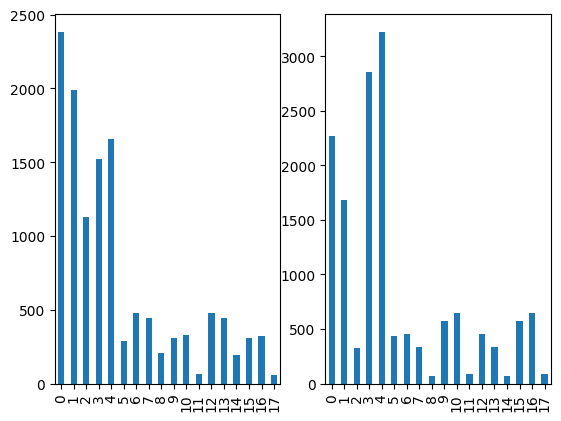

In [30]:
# test set과의 분포 비교

ax11 = plt.subplot(121)
ax22 = plt.subplot(122)

# 왼쪽 : 평가데이터 결과  /  오른쪽 : 훈련데이터 일부 결과
test_Series = submission['ans'].value_counts().sort_index()
test_Series.plot(kind = 'bar', ax = ax11)
t_Series.plot(kind='bar', ax = ax22)


In [31]:
standard = pd.read_csv('~/cv-12/log/standard_1028.csv')
submission = pd.read_csv('~/input/data/eval/submission.csv')

False_idx = (standard['ans'] == submission['ans']) == False
pd.Series(list(zip(submission[False_idx]['ans'], standard[False_idx]['ans']))).value_counts().head(20)

(1, 2)      538
(2, 1)      170
(7, 8)      109
(13, 14)    101
(5, 4)       89
(3, 4)       56
(4, 5)       52
(14, 13)     51
(4, 1)       45
(0, 1)       45
(0, 2)       44
(1, 4)       40
(3, 0)       37
(1, 0)       36
(8, 7)       33
(16, 17)     30
(2, 5)       25
(15, 16)     22
(0, 4)       20
(4, 3)       19
dtype: int64

In [32]:
# (자체) 각 class별로 정답개수 확인
g_sum = 0
a_sum = 0
m_sum = 0
device = torch.device('cuda')
model = basemodel_resnet18.to(device)
model.eval()

for i in range(len(mask_train_set)):
    image, label = mask_train_set[i]
    image = image.unsqueeze(0).to(device)
    
    result = model(image)
    if torch.argmax(result[0]) == label[0]:
        g_sum += 1
    if torch.argmax(result[1]) == label[1]:
        a_sum += 1
    if torch.argmax(result[2]) == label[2]:
        m_sum += 1
        
        
for i in range(len(mask_val_set)):
    image, label = mask_val_set[i]
    image = image.unsqueeze(0).to(device)
    
    result = model(image)
    if torch.argmax(result[0]) == label[0]:
        g_sum += 1
    if torch.argmax(result[1]) == label[1]:
        a_sum += 1
    if torch.argmax(result[2]) == label[2]:
        m_sum += 1
        

print(g_sum, a_sum , m_sum)

18797 18545 18882
